In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random
import cv2
from tifffile import imread
import tifffile as tiff
from PIL import Image

In [ ]:

images_path = '/content/drive/MyDrive/Data/data/images'
labels_path = '/content/drive/MyDrive/Data/data/labels'


In [ ]:
from tifffile import imread
img = imread('/content/drive/MyDrive/Data/data/images/0.tif')

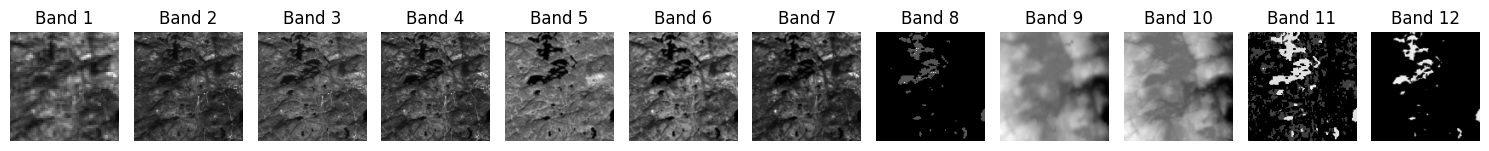

In [ ]:
num_bands = img.shape[-1]

fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

for i in range(num_bands):
    axes[i].imshow(img[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

image_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]

images = []
labels = []

for image_file in image_files:

    image_path = os.path.join(images_path, image_file)
    label_file = os.path.splitext(image_file)[0] + ".png"
    label_path = os.path.join(labels_path, label_file)

    image = tiff.imread(image_path)
    label = Image.open(label_path)

    label = np.array(label)

    label = (label > 0).astype(np.uint8)

    images.append(image)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Convert lists to TensorFlow tensors
images = tf.convert_to_tensor(np.array(images))
labels = tf.convert_to_tensor(np.array(labels))


In [ ]:
# Normalize each channel to the range [0, 1] for visualization
def normalize_channel(channel):
    min_val = np.min(channel)
    max_val = np.max(channel)
    return (channel - min_val) / (max_val - min_val)

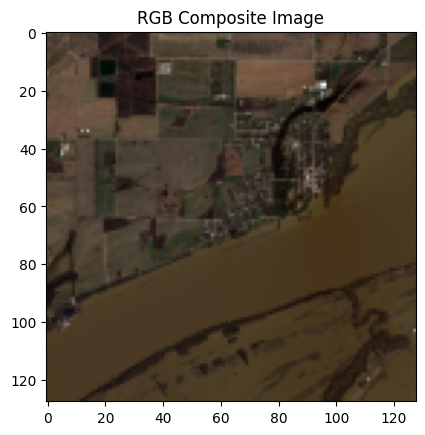

In [ ]:
# Extract bands for RGB composite
red_band = normalize_channel(image[:, :, 3])  # Band 4 - Red
green_band = normalize_channel(image[:, :, 2])  # Band 3 - Green
blue_band = normalize_channel(image[:, :, 1])  # Band 2 - Blue

# Stack bands to form an RGB image
rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

plt.figure()
plt.imshow(rgb_image)
plt.title('RGB Composite Image')
plt.show()

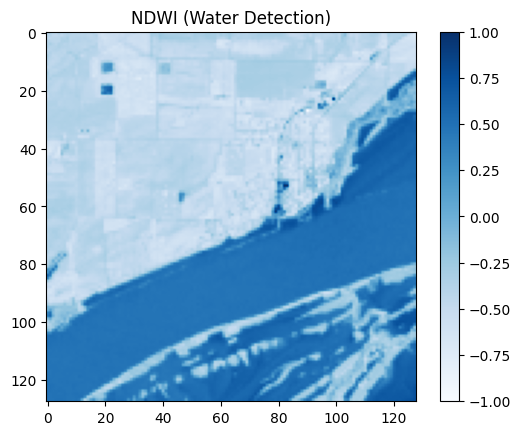

In [ ]:
nir_band = normalize_channel(image[:, :, 4])  # Band 5 - NIR
green_band = normalize_channel(image[:, :, 2])  # Band 3 - Green

# Calculate NDWI
ndwi = (green_band - nir_band) / (green_band + nir_band)

plt.figure()
plt.imshow(ndwi, cmap='Blues')  # Blue colormap to highlight water
plt.title('NDWI (Water Detection)')
plt.colorbar()
plt.show()

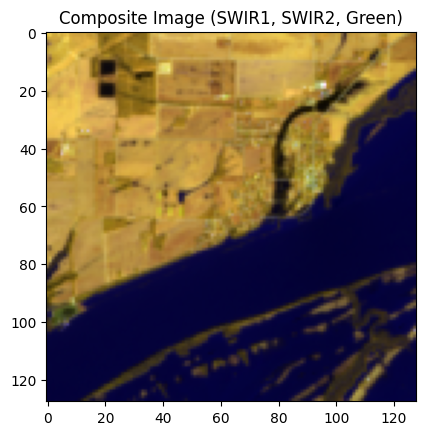

In [ ]:
swir1_band = normalize_channel(image[:, :, 5])  # Example SWIR 1
swir2_band = normalize_channel(image[:, :, 6])  # Example SWIR 2

# Create composite
composite_image = np.stack((swir1_band, swir2_band, green_band), axis=-1)  # SWIR1, SWIR2, Green

plt.figure()
plt.imshow(composite_image)
plt.title('Composite Image (SWIR1, SWIR2, Green)')
plt.show()

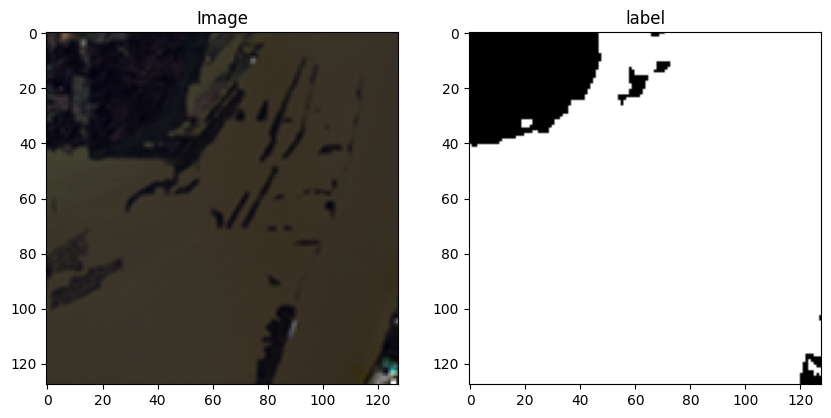

In [ ]:
# Select a random index
index = random.randint(0, len(images) - 1)

# Get the corresponding image and label
image = images[index]
label = labels[index]


# Extract bands for RGB composite
red_band = normalize_channel(image[:, :, 3])  # Band 4 - Red
green_band = normalize_channel(image[:, :, 2])  # Band 3 - Green
blue_band = normalize_channel(image[:, :, 1])  # Band 2 - Blue

# Stack bands to form an RGB image
rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

# Display the image and label
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb_image)
axes[0].set_title('Image')
axes[1].imshow(label, cmap='gray')
axes[1].set_title('label')
plt.show()


In [ ]:
def normalize_image(image):
    norm_img = np.zeros_like(image, dtype=np.float32)
    for b in range(image.shape[2]):
        band = image[:, :, b]
        min_val = np.min(band)
        max_val = np.max(band)
        if max_val != min_val:
            norm_img[:, :, b] = (band - min_val) / (max_val - min_val)
        else:
            norm_img[:, :, b] = 0
    return norm_img

In [ ]:
images_normalized = np.array([normalize_image(img) for img in images])

In [ ]:
# Assign each image to its corresponding label in a variable called training_data
training_data = tf.data.Dataset.from_tensor_slices((images_normalized, labels))

# Check the shapes of the loaded images and masks
print(f'Loaded {len(images)} images with shape {images.shape}')
print(f'Loaded {len(labels)} masks with shape {labels.shape}')

Loaded 306 images with shape (306, 128, 128, 12)
Loaded 306 masks with shape (306, 128, 128)


In [ ]:
# install library from github  https://github.com/qubvel/segmentation_models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-p9piffpi
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-p9piffpi
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 812.5 kB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33788 sha256=1fce21174c9b68124b2e25f6f1bae807f85a3d59bd02dd447b4c7add02976649
  Stored in directory: /tmp/pip-ephem-wheel-cache-_y3pk01d/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation_models


In [ ]:
import segmentation_models as sm
print(f"Segmentation Models version: {sm.__version__}")

Segmentation Models: using `keras` framework.
Segmentation Models version: 1.0.1


In [ ]:
import keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.0  # To avoid division by zero
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
import segmentation_models as sm
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

# Step 1: Define the backbone (ResNet50) and load the pre-trained U-Net model
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Load the U-Net model with pre-trained weights (encoder will be pre-trained on ImageNet)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')

# Step 2: Add a Conv2D layer to transform 12 channels to 3 channels
new_input = Input(shape=(128, 128, 12))
conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(new_input)

# Step 3: Pass the Conv2D output into the pre-trained U-Net model
pretrained_output = base_model(conv_layer)

# Step 4: Compile the modified model
model = Model(inputs=new_input, outputs=pretrained_output)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])



In [ ]:
# Print the model summary to verify the new input shape
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 3)         │             327 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_21 (Functional)           │ (None, 128, 128, 1)         │      32,561,114 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,561,441 (124.21 MB)

 Trainable params: 32,513,883 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [ ]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(training_data)


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 221s 22s/step - accuracy: 0.6043 - loss: 0.6937 - val_accuracy: 0.2445 - val_loss: 12.0386 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 155s 19s/step - accuracy: 0.8742 - loss: 0.4137 - val_accuracy: 0.2451 - val_loss: 12.0347 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 151s 19s/step - accuracy: 0.8911 - loss: 0.3186 - val_accuracy: 0.2398 - val_loss: 12.1201 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 204s 19s/step - accuracy: 0.9037 - loss: 0.2605 - val_accuracy: 0.2418 - val_loss: 12.0879 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 148s 19s/step - accuracy: 0.9147 - loss: 0.2220 - val_accuracy: 0.2418 - val_loss: 12.0862 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 161s 20s/step - accuracy: 0.9148 - loss: 0.2114 - val_accuracy: 0.2459 - val_loss: 12.0207 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 195s 19s/step - accuracy: 0.9201 - loss: 0.2007 - val_accu

In [ ]:
model.evaluate(test_data.batch(32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2407 - loss: 6.1861


[6.186110019683838, 0.24069786071777344]

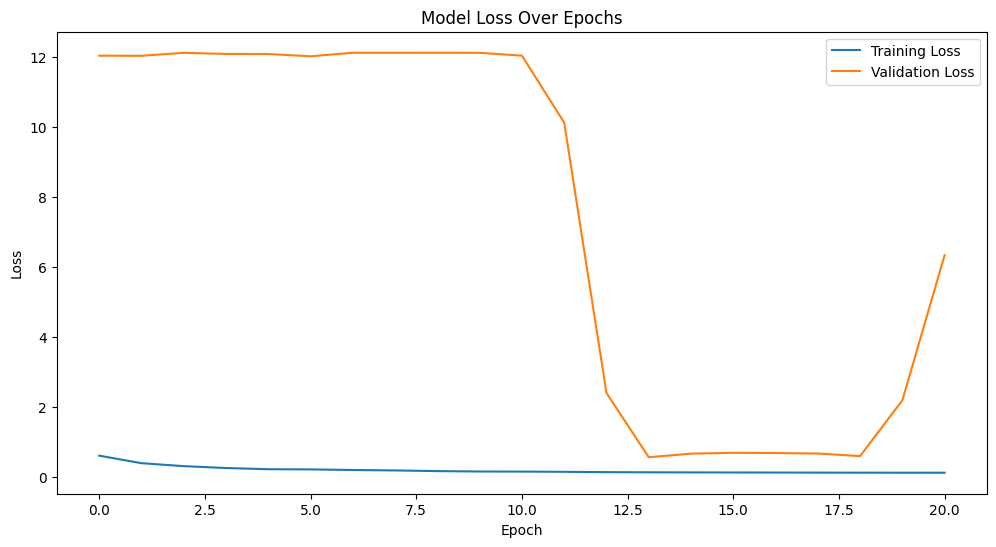

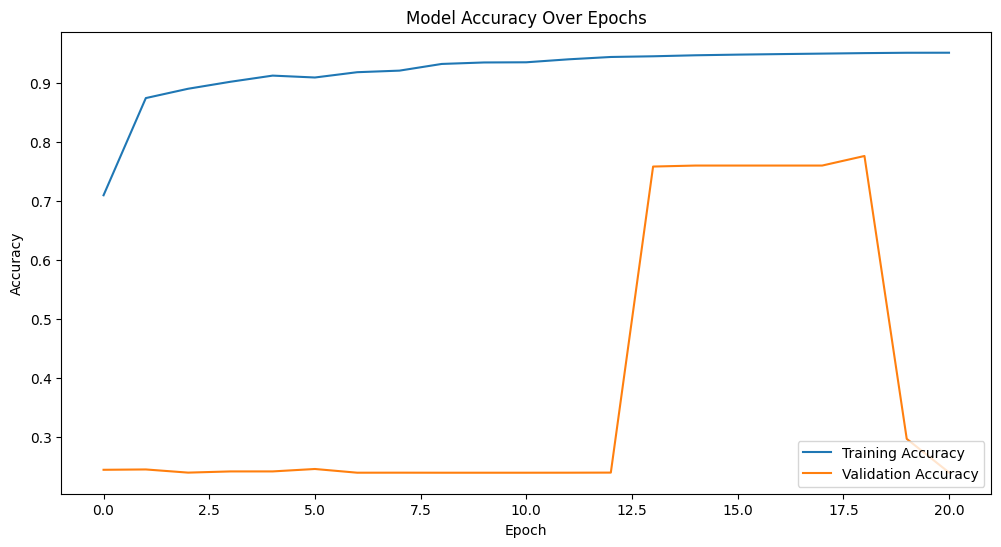

In [ ]:
#plot accuracy and loss
  # Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['loss'] , label='Training Loss')
plt.plot(model_history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'] , label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from keras.layers import Flatten
import keras.backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.0  # To avoid division by zero
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [ ]:
import segmentation_models as sm
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import keras.backend as K


# Step 2: Define the backbone (ResNet50) and load the pre-trained U-Net model
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Load the U-Net model with pre-trained weights (encoder will be pre-trained on ImageNet)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')

# Step 3: Add a Conv2D layer with kernel regularization (L2) to transform 12 channels to 3 channels
new_input = Input(shape=(128, 128, 12))
conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu',
                    kernel_regularizer=l2(0.01))(new_input)

# Step 4: Pass the Conv2D output into the pre-trained U-Net model
pretrained_output = base_model(conv_layer)

# Step 5: Compile the modified model using the custom Dice loss
model = Model(inputs=new_input, outputs=pretrained_output)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 3)         │             327 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_33 (Functional)           │ (None, 128, 128, 1)         │      32,561,114 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,561,441 (124.21 MB)

 Trainable params: 32,513,883 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [ ]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 208s 20s/step - accuracy: 0.7312 - loss: 0.6362 - val_accuracy: 0.7554 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 191s 19s/step - accuracy: 0.8441 - loss: 0.4063 - val_accuracy: 0.7514 - val_loss: 1.0162 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 199s 18s/step - accuracy: 0.8784 - loss: 0.3246 - val_accuracy: 0.7538 - val_loss: 0.9942 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 207s 19s/step - accuracy: 0.8954 - loss: 0.2730 - val_accuracy: 0.7603 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 203s 19s/step - accuracy: 0.9013 - loss: 0.2492 - val_accuracy: 0.7594 - val_loss: 1.0298 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 197s 18s/step - accuracy: 0.8936 - loss: 0.2581 - val_accuracy: 0.7105 - val_loss: 0.8977 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 202s 18s/step - accuracy: 0.9042 - loss: 0.2353 - val_accuracy: 

In [ ]:
model.evaluate(test_data.batch(32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7595 - loss: 1.0276


[1.0275936126708984, 0.75946044921875]

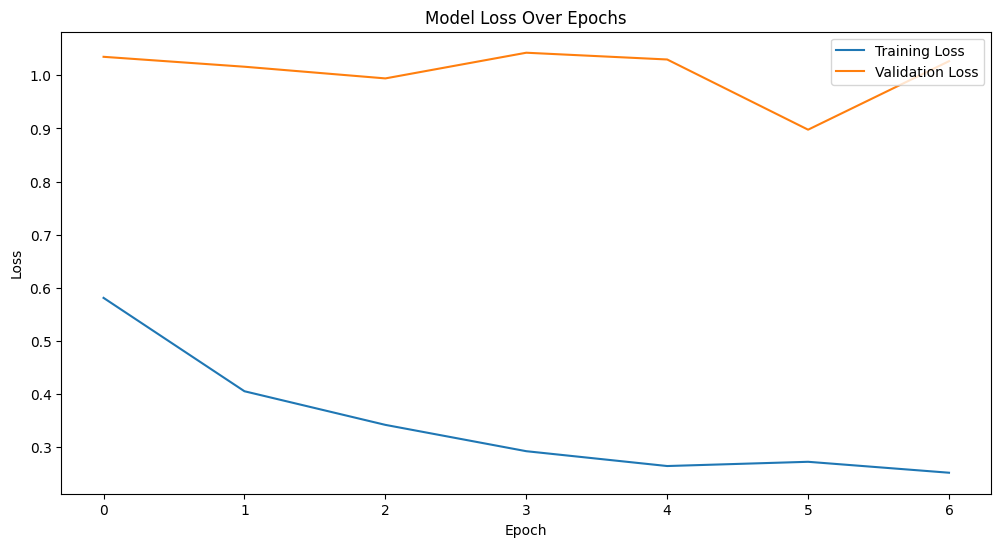

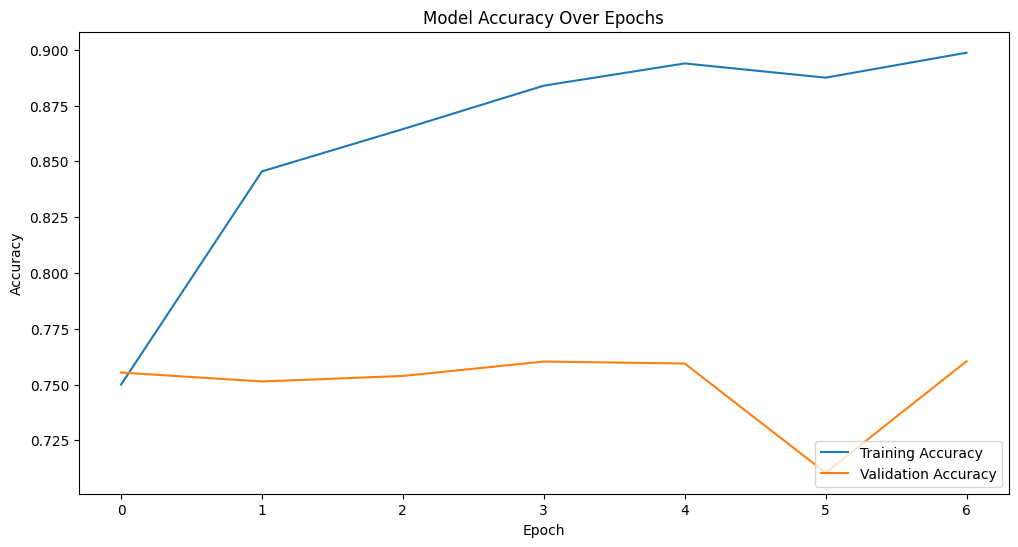

In [ ]:
#plot accuracy and loss
  # Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['loss'] , label='Training Loss')
plt.plot(model_history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'] , label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import os
import tifffile as tiff
import tensorflow as tf
import numpy as np

# Initialize lists to hold images and labels
images = []
labels = []
# Load and preprocess images and labels
for filename in os.listdir(images_path):
    if filename.endswith('.tif'):  # For .tif images
        # Load and preprocess image using tifffile
        image = tiff.imread(os.path.join(images_path, filename))
        image = tf.image.resize(image, [128, 128])
        image = image / 65535.0  # Normalize to [0, 1] (assuming 16-bit images)

        # Load and preprocess corresponding label
        label_filename = filename.replace('.tif', '.png')  # Adjust extension for the label
        label = tf.io.read_file(os.path.join(labels_path, label_filename))
        label = tf.image.decode_png(label, channels=1)  # Decode label as grayscale
        label = tf.image.resize(label, [128, 128])  # Resize to match the image
        label = tf.cast(label, tf.int32)  # Convert label to integer type

        # Append to lists
        images.append(image)
        labels.append(label)

# Convert lists to TensorFlow tensors
images = tf.convert_to_tensor(np.array(images))
labels = tf.convert_to_tensor(np.array(labels))

# Assign each image to its corresponding label in a variable called training_data
training_data = tf.data.Dataset.from_tensor_slices((images, labels))



In [ ]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(training_data)


In [ ]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 191s 21s/step - accuracy: 0.8947 - loss: 0.2487 - val_accuracy: 0.7582 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 185s 19s/step - accuracy: 0.8905 - loss: 0.2664 - val_accuracy: 0.7604 - val_loss: 0.9974 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 151s 18s/step - accuracy: 0.9121 - loss: 0.2163 - val_accuracy: 0.7600 - val_loss: 1.0358 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 157s 20s/step - accuracy: 0.9065 - loss: 0.2248 - val_accuracy: 0.7604 - val_loss: 0.9873 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 148s 19s/step - accuracy: 0.9140 - loss: 0.2094 - val_accuracy: 0.7604 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 204s 19s/step - accuracy: 0.9190 - loss: 0.1984 - val_accuracy: 0.7604 - val_loss: 1.0355 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 153s 19s/step - accuracy: 0.9210 - loss: 0.1935 - val_accuracy: 

In [ ]:
import segmentation_models as sm
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import keras.backend as K


# Step 2: Define the backbone (ResNet18) and load the pre-trained U-Net model
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Load the U-Net model with pre-trained weights (encoder will be pre-trained on ImageNet)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')

# Step 3: Add a Conv2D layer with kernel regularization (L2) to transform 12 channels to 3 channels
new_input = Input(shape=(128, 128, 12))
conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(new_input)

# Step 4: Pass the Conv2D output into the pre-trained U-Net model
pretrained_output = base_model(conv_layer)

# Step 5: Compile the modified model using the custom Dice loss
model = Model(inputs=new_input, outputs=pretrained_output)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 3)         │             327 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 128, 128, 1)         │      14,340,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,340,897 (54.71 MB)

 Trainable params: 14,330,971 (54.67 MB)

 Non-trainable params: 9,926 (38.77 KB)

In [ ]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.5944 - loss: 0.5933 - val_accuracy: 0.7519 - val_loss: 0.9529 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - accuracy: 0.8009 - loss: 0.4066 - val_accuracy: 0.2808 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.8699 - loss: 0.3204 - val_accuracy: 0.2918 - val_loss: 0.6115 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8942 - loss: 0.2642 - val_accuracy: 0.3096 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9072 - loss: 0.2225 - val_accuracy: 0.7599 - val_loss: 0.9699 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9181 - loss: 0.1864 - val_accuracy: 0.7464 - val_loss: 0.8654 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9241 - loss: 0.1685 - val_accuracy: 0

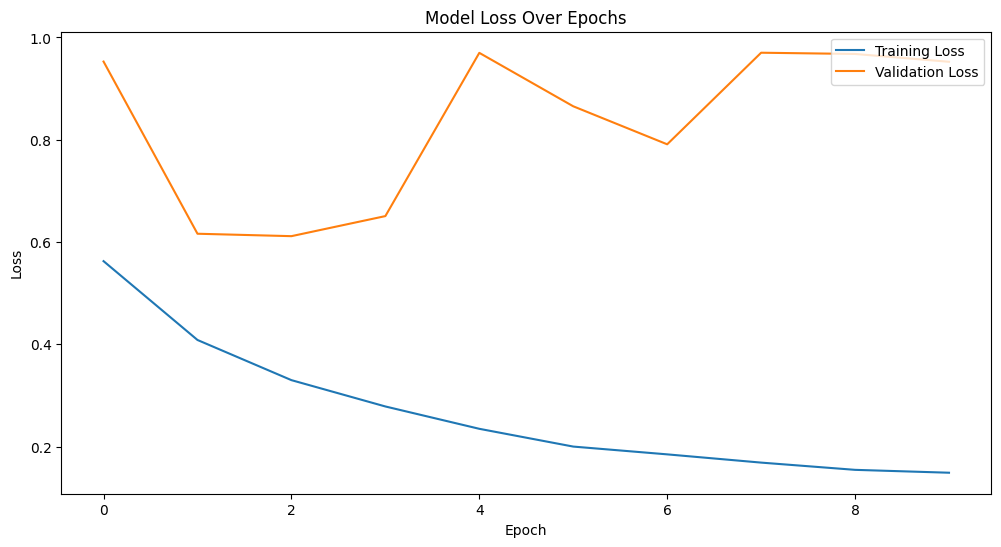

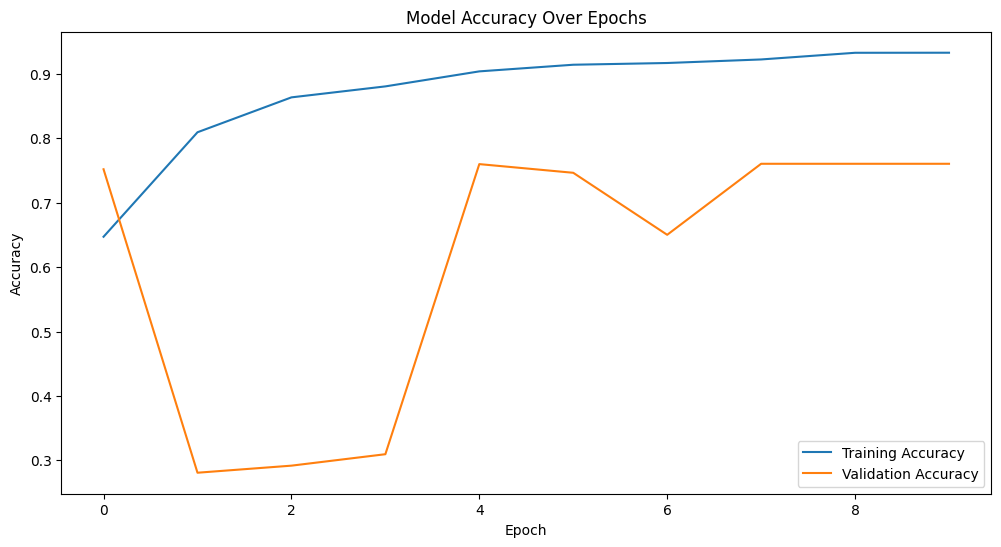

In [ ]:
#plot accuracy and loss
  # Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['loss'] , label='Training Loss')
plt.plot(model_history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'] , label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.evaluate(test_data.batch(32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7595 - loss: 0.9566


[0.9566423296928406, 0.75946044921875]

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    # Ensure that y_true and y_pred are cast to float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    smooth = 1.0  # To avoid division by zero
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D
import segmentation_models as sm
from tensorflow.keras import backend #Import backend

# Choose the backbone
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Custom input with 12 channels
input_layer = Input(shape=(128, 128, 12))

# Add a Conv2D layer to reduce channels from 12 to 3
conv_layer = Conv2D(3, (1, 1), padding='same', activation='relu')(input_layer)

# Load the U-Net model with pretrained ImageNet weights
base_model = sm.Unet(BACKBONE, input_shape=(128, 128, 3), classes=1, activation='sigmoid', encoder_weights='imagenet')

# Apply the backbone model to the Conv2D output
output = base_model(conv_layer)

# Create the new model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer='Adam', loss=dice_loss, metrics=[sm.metrics.iou_score])


In [ ]:
# Model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 12)]    0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 3)       39        
                                                                 
 model_2 (Functional)        (None, 128, 128, 1)       10115501  
                                                                 
Total params: 10115540 (38.59 MB)
Trainable params: 10071540 (38.42 MB)
Non-trainable params: 44000 (171.88 KB)
_________________________________________________________________


In [ ]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(training_data)


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )

Epoch 1/30
8/8 [==============================] - 38s 2s/step - loss: 0.5846 - iou_score: 0.2709 - val_loss: 0.5752 - val_iou_score: 0.2697 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 13s 2s/step - loss: 0.3806 - iou_score: 0.4547 - val_loss: 0.4572 - val_iou_score: 0.3725 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 11s 1s/step - loss: 0.2996 - iou_score: 0.5446 - val_loss: 0.5697 - val_iou_score: 0.2741 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - 12s 2s/step - loss: 0.2383 - iou_score: 0.6202 - val_loss: 0.4533 - val_iou_score: 0.3762 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 11s 1s/step - loss: 0.2028 - iou_score: 0.6695 - val_loss: 0.4956 - val_iou_score: 0.3372 - lr: 0.0010
Epoch 6/30
8/8 [==============================] - 11s 1s/step - loss: 0.1837 - iou_score: 0.6959 - val_loss: 0.4974 - val_iou_score: 0.3356 - lr: 0.0010
Epoch 7/30
8/8 [==============================] - 11s 1s/step - loss: 0.1655 - iou

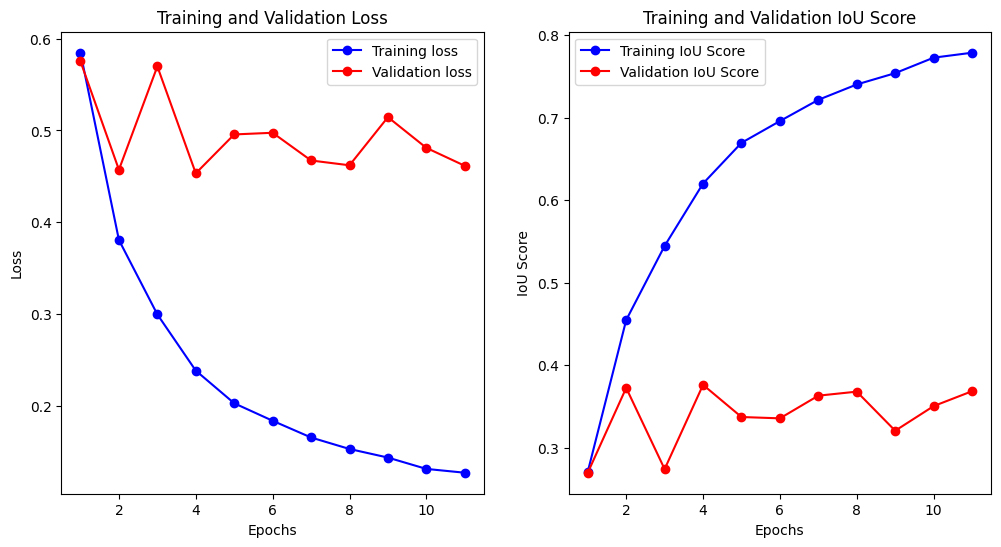

In [ ]:
import matplotlib.pyplot as plt

# Assuming model_history is returned from model.fit()
# model_history = model.fit(...)

# Plot training & validation loss values
def plot_training_history(history):
    # Get the data from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Check if accuracy (or other metrics) exists in history
    if 'iou_score' in history.history:
        iou_score = history.history['iou_score']
        val_iou_score = history.history['val_iou_score']

    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy/IoU
    if 'iou_score' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, iou_score, 'bo-', label='Training IoU Score')
        plt.plot(epochs, val_iou_score, 'ro-', label='Validation IoU Score')
        plt.title('Training and Validation IoU Score')
        plt.xlabel('Epochs')
        plt.ylabel('IoU Score')
        plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(model_history)


/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  warnings.warn(


Epoch 1/30
8/8 [==============================] - 35s 2s/step - loss: 0.6083 - iou_score: 0.2453 - val_loss: 0.6721 - val_iou_score: 0.1961 - lr: 1.0000e-04
Epoch 2/30
8/8 [==============================] - 10s 1s/step - loss: 0.5761 - iou_score: 0.2706 - val_loss: 0.6746 - val_iou_score: 0.1943 - lr: 1.0000e-04
Epoch 3/30
8/8 [==============================] - 10s 1s/step - loss: 0.5563 - iou_score: 0.2868 - val_loss: 0.6770 - val_iou_score: 0.1926 - lr: 1.0000e-04
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 0.5414 - iou_score: 0.2992 - val_loss: 0.6817 - val_iou_score: 0.1893 - lr: 1.0000e-04
Epoch 5/30
8/8 [==============================] - 10s 1s/step - loss: 0.5289 - iou_score: 0.3101 - val_loss: 0.6848 - val_iou_score: 0.1871 - lr: 1.0000e-04
Epoch 6/30
8/8 [==============================] - ETA: 0s - loss: 0.5154 - iou_score: 0.3216
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-05.
8/8 [==============================] - 11s 1s/step - loss: 0.5

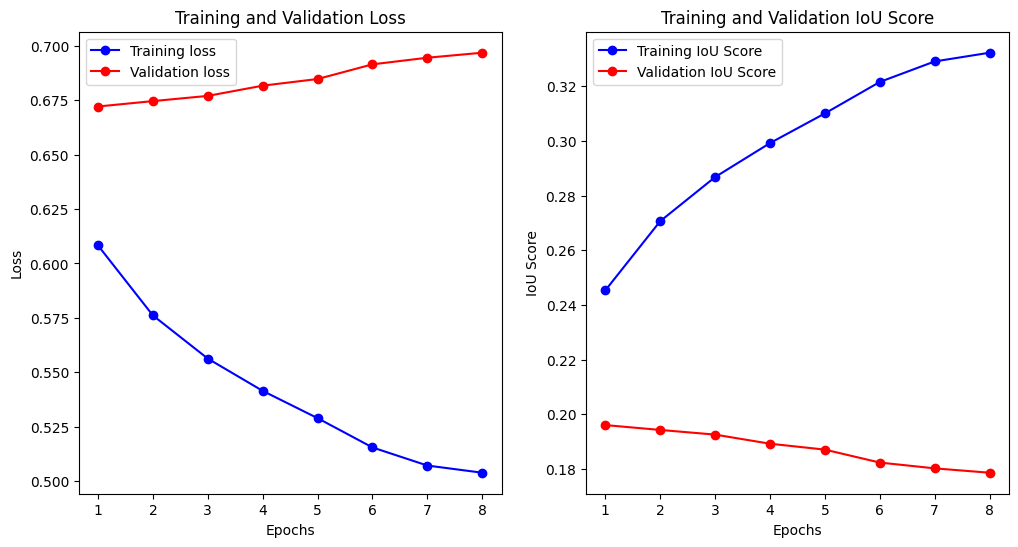

In [ ]:
import segmentation_models as sm
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing the input to match the segmentation models
preprocess_input = sm.get_preprocessing('efficientnetb0')

# Build the U-Net model with EfficientNetB0 as the backbone
base_model = sm.Unet(
    backbone_name='efficientnetb0',
    input_shape=(128, 128, 12),  # Assuming 12-channel input
    classes=1,  # Binary segmentation
    activation='sigmoid',
    encoder_weights=None  # No pretrained weights since we're dealing with 12 channels
)

# Add dropout layers for regularization
x = base_model.layers[-2].output  # Taking the second last layer
x = layers.Dropout(0.5)(x)  # 40% dropout rate for regularization
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Adjusting the output layer

# Final model
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compile with dice loss and Adam optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=[sm.metrics.iou_score])



# Train the model
model_history = model.fit(
    train_data.batch(32),
    validation_data=val_data.batch(32),
    epochs=30,
    callbacks=[callbacks]
)

# Plotting the training and validation loss
plot_training_history(model_history)


In [ ]:
import keras
print(keras.__version__)


2.15.0
